# Dacon 이미지 초해상화
품질이 저하된 저해상도 촬영 이미지(512X512)를 고품질의 고해상도 촬영 이미지(2048X2048)로 생성

<br>
train patch 128*128 : 1640 X 16 = 26240개 patch<br>
test patch 128*128 :  18 X 49 = 882개 patch
<Br>

SRGAN PSNR : 12.8715          
EDSR PSNR : 20.0568 <br>
SWINIR PSNR : 22.1805 <Br>





#Setting

## Drive Mount & Install Library

In [ ]:
from google.colab import drive
drive.mount("/content/drive",force_remount = True)

Mounted at /content/drive


In [ ]:
!pip install timm
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Library

In [ ]:
import random
import pandas as pd
import numpy as np
import os
import sys
import cv2
import zipfile
import math
import itertools
import matplotlib.pyplot as plt
import argparse


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.cuda import amp
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchvision.models import *
from torchvision.datasets import *
import torchvision.models as mondels

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action = "ignore")
from patchify import patchify, unpatchify
from PIL import Image

# for image augmentation
import albumentations as A 
from albumentations.pytorch.transforms import ToTensorV2

##GPU Check

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
device #cuda 할당 확인 

device(type='cuda', index=0)

In [ ]:
# GPU 이름 체크(cuda:0에 연결된 그래픽 카드 기준)
print(torch.cuda.get_device_name()) # 'A100-SXM4-40GB'

# 사용 가능 GPU 개수 체크
print(torch.cuda.device_count()) # 1

Tesla T4
1


## Hyperparameter

### EDSR, SWIN

In [ ]:
CFG = {
    "EDSR_EPOCHS" : 7,
    "EDSR_LEARNING_RATE" : 1e-4,
    "SWIN_EPOCHS" : 5,
    "SWIN_LEARNING_RATE" : 2e-4,
    "SWIN_MILESTONES" : [2,3],
    "EDSR_TRAIN_BATCH" : 4, #2
    "SWIN_TRAIN_BATCH":10,
    'TEST_BATCH' : 1, 
    "SEED" : 42,
}

###SRGAN

In [ ]:
# 프로그램 실행시에 하이퍼파라미터를 쉽게 관리할 수 있도록 함
parser = argparse.ArgumentParser() 
parser.add_argument("--epoch", type=int, default=0, help="epoch to start training from")
parser.add_argument("--n_epochs", type=int, default=10, help="number of epochs of training")
parser.add_argument("--dataset_name", type=str, default="img_align_celeba", help="name of the dataset")
parser.add_argument("--batch_size", type=int, default=4, help="size of the batches")
parser.add_argument("--lr", type=float, default=0.0002, help="adam: learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.999, help="adam: decay of first order momentum of gradient")
parser.add_argument("--decay_epoch", type=int, default=100, help="epoch from which to start lr decay")
parser.add_argument("--n_cpu", type=int, default=8, help="number of cpu threads to use during batch generation")
parser.add_argument("--hr_height", type=int, default=512, help="high res. image height")
parser.add_argument("--hr_width", type=int, default=512, help="high res. image width")
parser.add_argument("--channels", type=int, default=3, help="number of image channels")
parser.add_argument("--sample_interval", type=int, default=100, help="interval between saving image samples")
parser.add_argument("--checkpoint_interval", type=int, default=-1, help="interval between model checkpoints")
opt = parser.parse_args(args=[])
print(opt)

Namespace(b1=0.5, b2=0.999, batch_size=4, channels=3, checkpoint_interval=-1, dataset_name='img_align_celeba', decay_epoch=100, epoch=0, hr_height=512, hr_width=512, lr=0.0002, n_cpu=8, n_epochs=10, sample_interval=100)


#Seed 고정

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ["PYTHONHASHSEED"] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(42) #seed 고정

# Patch 형성

##Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from patchify import patchify
import tifffile as tiff

def making_patches(img_path,patch_size, train = True, is_lr = True):
  img_name = img_path.split("/")[-1][:-4]
  sample_large_img = cv2.imread(img_path) # 여기서 BGR로 읽고 잘라서 그럼

  patches_img = patchify(sample_large_img, (patch_size,patch_size,3), step  = patch_size) ##patch 형성
  

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):

      #one each patch
      single_patch_img = patches_img[i,j, :,:, :]#patch 한장
      single_patch_img = np.squeeze(single_patch_img, axis = 0)

      #saving on patch
      if train :
        if is_lr:
          lr_file = "/content/drive/MyDrive/patches_new/lr/{}_{}_{}.png".format(img_name, i,j)
          if not os.path.isfile(lr_file):
            cv2.imwrite(lr_file,single_patch_img)
        else:
          hr_file = "/content/drive/MyDrive/patches_new/hr/{}_{}_{}.png".format(img_name, i,j)
          if not os.path.isfile(hr_file):
            cv2.imwrite(hr_file,single_patch_img)

      else:
        test_file ="./patches_new/test_new/{}_{}_{}.png".format(img_name, i,j)
        # test_file ="/content/drive/MyDrive/test_new/{}_{}_{}.png".format(img_name, i,j)
        if not os.path.isfile(test_file):
          cv2.imwrite(test_file,single_patch_img)

  print("processing :", img_name)

##Train patch

In [ ]:
path = "/content/drive/Shareddrives/2022-2 KUBIG CV 이미지초해상도/Data"
os.chdir(path)
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

for i in range(len(train_df)):
  lr_path = train_df["LR"].iloc[i]
  hr_path = train_df["HR"].iloc[i]

  making_patches(lr_path, 128, train = True, is_lr = True)
  making_patches(hr_path, 512 ,train = True, is_lr = False)


#마지막 실행 : "/content/drive/MyDrive/patches_new 에 저장함

In [ ]:
#train patch 생성 : 1640 -> 1640*16(26240), non-overlapping
patch_df=  pd.DataFrame(columns = ["LR", "HR"])
for idx in range(len(train_df)):
  file_name = train_df["LR"][idx].split("/")[-1][:-4]
  for i in range(4):
    for j in range(4):
      temp = pd.DataFrame({"LR" : [f"./patches_new/lr_new/{file_name}_{i}_{j}.png"],
                           "HR" : [f"./patches_new/hr_new/{file_name}_{i}_{j}.png"]})
      patch_df = patch_df.append(temp)
print(len(patch_df))
print(patch_df.head())
patch_df.to_csv(path+"/patch_train.csv", index = False)

## Test patch

In [ ]:
path = "/content/drive/Shareddrives/2022-2 KUBIG CV 이미지초해상도/Data"
os.chdir(path)
test_df = pd.read_csv("./test.csv")

for i in range(len(test_df)):
  test_lr_path = test_df["LR"].iloc[i]

  making_patches(test_lr_path,128, train = False,is_lr = True)

#마지막 실행 : "/content/drive/MyDrive/test_new 에 저장함

In [ ]:
##train patch 생성 : 18 -> 18*49(882), overlapping
patch_test_df=  pd.DataFrame(columns = ["LR"])
for idx in range(len(test_df)):
  file_name = test_df["LR"][idx].split("/")[-1][:-4]
  for i in range(7):
    for j in range(7):
      temp = pd.DataFrame({"LR" : [f"./patches_new/test_new/{file_name}_{i}_{j}.png"]})
      patch_test_df = patch_test_df.append(temp)
print(len(patch_test_df))
print(patch_test_df.head())
patch_test_df.to_csv(path+"/patch_test.csv", index = False)

#Custom Dataset


기본 1640개의 train data, 18개의 test data

*   Train patch: 1장당 균일하게 16등분 (nonoverlapping)
*   lr: 512 -> 128, hr: 2048 -> 512
*   총 1640 * 16 = 26240개 patch



*   Test patch: 1장당 49개의 patch (overlapping)
*   stride = 64 -> (512-128)/64 + 1 = 7
*   7*7 49장의 test patch


train, test 원본은 RGB <br>
train, test patch는 BGR data

## Augmentation

In [ ]:
## img to Tensor transforms functions

def get_train_transform():

  #모두 Non-destructive transformations <- 정보를 추가하거나 손실하지 않게 
  return A.Compose([
      A.RandomRotate90(p=0.7),    
      A.OneOf([
          A.HorizontalFlip(p=1), #수평회전
          A.VerticalFlip(p=1),
          A.ShiftScaleRotate(p=1)],p=0.7), #수직회전
      A.Transpose(p=0.7), #X,Y축 반전
      ToTensorV2(p = 1.0)],
      additional_targets = {"image" : "image", "label":"image"}
  )       
      

def get_test_transform(): 

  return A.Compose([
      ToTensorV2(p = 1.0)],
      additional_targets ={"image" : "image"}
  )


## Training Dataset

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, df, transforms, train_mode,base_path, augmentation):
    self.df = df
    self.transforms = transforms #image(png) to Tensor
    self.augmentation = augmentation 
    self.train_mode = train_mode
    self.base_path = base_path

  def __getitem__(self, index): #batch loader
    lr_path = self.df["LR"].iloc[index]
    lr_path = self.base_path +lr_path[1:] 

    lr_img = cv2.imread(lr_path) #load images(BGR)
    
    # lr_img = cv2.cvtColor(lr_img, cv2.COLOR_BGR2RGB)  #BGR to RGB

    
    if self.train_mode:
      #load hr_images as label
      hr_path = self.df["HR"].iloc[index]
      hr_path = self.base_path + hr_path[1:]

      hr_img = cv2.imread(hr_path) #load images(BGR)

      # hr_img = cv2.cvtColor(hr_img, cv2.COLOR_BGR2RGB) #BGR to RGB


      if self.transforms is not None:
        #image to Tensor (with labels)
        transformed = self.transforms(image = lr_img, label = hr_img)
        lr_img = transformed["image"] / 255. # normalization
        hr_img = transformed["label"] / 255.

      # return lr_img, hr_img
      return {'L': lr_img, 'H': hr_img, 'L_path': lr_path, 'H_path': hr_path}

    else:
      #test mode
      #test dataset은 LR 밖에 없다.
      file_name = lr_path.split("/")[-1] ##0000.png

      if self.transforms is not None:
        transformed = self.transforms(image = lr_img)
        lr_img = transformed["image"] / 255.
      
      # return lr_img, file_name
      return {"L" : lr_img, "L_path" : lr_path}

  def __len__(self):
    return len(self.df)

In [ ]:
base_path = "/content/drive/Shareddrives/2022-2 KUBIG CV 이미지초해상도/Data"

train_df = pd.read_csv(base_path +"/patch_train.csv")


#train_df가 우리 원본 파일명들 들어있는 train.csv 파일을 말함
#경로 설정 잘해야함. 
train_dataset = CustomDataset(train_df, get_train_transform(), True, base_path, augmentation = True) #train_mode = true

valid_size = 0.2


#validation으로 사용할 trainning indices를 얻는다.
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices) #train data는 shuffle해도 됨
split = int(np.floor(valid_size * num_train)) #np.floor = 가우스 
train_idx, valid_idx = indices[split:], indices[:split]

# trainning, validation batch를 얻기 위한 sampler정의
train_sampler = SubsetRandomSampler(train_idx) #SubsetRandomSampler: 랜덤리스트 
valid_sampler = SubsetRandomSampler(valid_idx)


train_loader = DataLoader(train_dataset, batch_size = CFG["EDSR_TRAIN_BATCH"],
                          sampler = train_sampler, num_workers = 4,
                          drop_last = True, pin_memory = True)

swin_train_loader = DataLoader(train_dataset, batch_size = CFG["SWIN_TRAIN_BATCH"],
                          sampler = train_sampler, num_workers = 4,
                          drop_last = True, pin_memory = True)

#drop last를 하면 data의 개수가 batch_size로 나눠떨어지지 않을때 마지막 batch 버려준다.
#pin_memory = True : 데이터로더는 Tensor를 CUDA 고정 메모리에 올린다. 
#Dataset이 매우 작을때, 이미 data가 GPU상에 다 올라가 있을 때를 제외하고서는 pin_memory = True가 좋은듯.


valid_loader = DataLoader(train_dataset, batch_size = CFG["EDSR_TRAIN_BATCH"],
                          sampler = valid_sampler, num_workers = 4,
                          drop_last = True,pin_memory = True)

swin_valid_loader = DataLoader(train_dataset, batch_size = CFG["SWIN_TRAIN_BATCH"],
                          sampler = valid_sampler, num_workers = 4,
                          drop_last = True,pin_memory = True)


## Test Dataset

In [ ]:
#새롭게 만든 7x7 총 18장 * 49 장의 patch들로 만든 dataset
patch_test = pd.read_csv("/content/drive/MyDrive/이미지초해상화/patches_new/patch_test_49.csv")
test_dataset = CustomDataset(patch_test,get_test_transform(), False ,"/content/drive/MyDrive/이미지초해상화", augmentation = False)
test_loader = DataLoader(test_dataset,
                         batch_size = 1,
                         shuffle = False,
                         num_workers = 4,
                         drop_last = False,
                         pin_memory= False)

for dict in test_loader:
  print(dict["L"].shape)   #b * c * H* W 순
  break

torch.Size([1, 3, 128, 128])


#Function

### EarlyStopping

In [ ]:
# from pytorchtools import EarlyStopping
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Train

In [ ]:
def train(model, optimizer, scheduler, device, patience, n_epochs):

  model.to(device)
  criterion_1 =  nn.L1Loss().to(device)     #L1 loss 사용, 일반적으로 L2가 PSNR을 최대화하는데 더 좋다고 알려져 있지만, 
  criterion_2 =  nn.MSELoss().to(device)    #L1 loss가 better convergence를 하게 해준다.

 # (L1loss:L2loss = 2:1)


  best_model = None
  best_loss = 9999

  train_losses = []
  valid_losses = []
  avg_train_losses = []
  avg_valid_losses = []  

  # early_stopping object의 초기화
  early_stopping = EarlyStopping(patience = patience, verbose = True)


  for epoch in range(1, n_epochs + 1):


      #########################
      #### train the model ####
      #########################

      model.train()
      # train_loss = []
      for i, img_pair in enumerate(tqdm((train_loader))):
        lr_img, hr_img = img_pair["L"].float().to(device), img_pair["H"].float().to(device)

        optimizer.zero_grad()

        pred_hr_img = model(lr_img)
        loss_1 = criterion_1(pred_hr_img.to(torch.float32), hr_img.to(torch.float32)) #합산 연산하려는 두 배열의 데이터 타입 float32로 통일
        loss_2 = criterion_2(pred_hr_img.to(torch.float32), hr_img.to(torch.float32))

        loss = loss_1 * 2/3 + loss_2 * 1/3  # (L1loss:L2loss = 2:1) <- convergence를 위해 L1에 가중치를 더 주면서도, PSNR 높이기 위해 L2 첨가

        loss.backward()
        optimizer.step() #가중치 갱신 

        train_losses.append(loss.item())

      if scheduler is not None:
        scheduler.step()


      # #epoch 마다 trian loss checking해서 제일 작은 거 선택하기 위함
      # if best_loss > _train_loss:
      #   best_loss = _train_loss
      #   best_model = model

      print("finish the training")

      ######################    
      # validate the model #
      ######################
      model.eval() # prep model for evaluation
      for i, img_pair in enumerate(tqdm((valid_loader))):
        lr_img, hr_img = img_pair["L"].float().to(device), img_pair["H"].float().to(device)

        pred_hr_img = model(lr_img)
        loss_1 = criterion_1(pred_hr_img.to(torch.float32), hr_img.to(torch.float32)) #합산 연산하려는 두 배열의 데이터 타입 float32로 통일
        loss_2 = criterion_2(pred_hr_img.to(torch.float32), hr_img.to(torch.float32))
  
        loss = loss_1 * 2/3 + loss_2 * 1/3
        valid_losses.append(loss.item())

      # print 학습/검증 statistics
      # epoch당 평균 loss 계산
      train_loss = np.average(train_losses)
      valid_loss = np.average(valid_losses)
      avg_train_losses.append(train_loss)
      avg_valid_losses.append(valid_loss)

      epoch_len = len(str(n_epochs))
      batch_len = len(valid_loader)
      
      print_msg = (f'[Epoch {epoch}/{epoch_len}]' +
                   f'[Batch {i}/{batch_len}]' +
                   f'train_loss(L1+L2): {train_loss:.5f} ' +
                   f'valid_loss(L1+L2): {valid_loss:.5f}')
      



      print(print_msg)

      # clear lists to track next epoch
      train_losses = []
      valid_losses = []

      # early_stopping는 validation loss가 감소하였는지 확인이 필요하며,
      # 만약 감소하였을경우 현제 모델을 checkpoint로 만든다.
      early_stopping(valid_loss, model)

      if early_stopping.early_stop:
          print("Early stopping")
          break

   # best model이 저장되어있는 last checkpoint를 로드한다.
  model.load_state_dict(torch.load('checkpoint.pt'))

  return  model, avg_train_losses, avg_valid_losses


In [ ]:
def train_GAN(generator, discriminator, optimizer_D, optimizer_G, train_loader, device, epochs ):

  criterion_GAN = torch.nn.MSELoss()      # Adversarial loss
  criterion_content = torch.nn.L1Loss()   # Content loss
  criterion_GAN = criterion_GAN.cuda()
  criterion_content = criterion_content.cuda()

  best_model = None
  best_loss = 9999

  for epoch in range(0, epochs + 1):
      train_loss_G = []
      train_loss_D = []

      for i, img_pair in enumerate(tqdm((train_loader))):

        #lr_img, hr_img = img_pair["L"].float().to(device), img_pair["H"].float().to(device)

        lr_img = Variable(img_pair["L"].type(Tensor))
        hr_img = Variable(img_pair["H"].type(Tensor))

        # Adversarial ground truths
        valid = Variable(Tensor(np.ones((lr_img.size(0), *discriminator.output_shape))), requires_grad=False) #discriminator real --> 1
        fake = Variable(Tensor(np.zeros((lr_img.size(0), *discriminator.output_shape))), requires_grad=False) #discriminator fake --> 0

        optimizer_G.zero_grad()

        # Generate a high resolution image from low resolution input
        gen_hr = generator(lr_img)

        # Adversarial loss - generator로 부터 생성된 이미지가 DIscriminator를 통과하면서 adversarial loss를 통해 작동
        loss_GAN = criterion_GAN(discriminator(gen_hr), valid) # 여기선 BCE를 사용해야하지 않나?  probability를 바탕으로 구하니까

        # Content loss
        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(hr_img)
        loss_content = criterion_content(gen_features, real_features.detach()) #euclidean distance를 구해야 하는데 왜 L1loss를 썼지?
                                                                               # MSE를 써야할듯

        # Total loss (Perceptual loss function)
        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        train_loss_G.append(loss_G.item())

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss of real and fake images
        loss_real = criterion_GAN(discriminator(hr_img), valid) #진짜 real과 얼마나 차이나는지?
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake) #진짜 fake와 얼마나 차이나는지?

        # Total loss
        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        train_loss_D.append(loss_D.item())


        sys.stdout.write(
            "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]\n"
            % (epoch, epochs, i, len(train_loader), loss_D.item(), loss_G.item())
        )

      _train_loss_G = np.mean(train_loss_G)
      _train_loss_D = np.mean(train_loss_D)
      print(f"Epoch : [{epoch}] Train Loss G : [{_train_loss_G:.5f}] Train Loss D : [{_train_loss_D:.5f}]") # train loss epoch 평균값

      #epoch 마다 trian loss checking해서 제일 작은 거 선택하기 위함
      if best_loss > _train_loss_G:
        best_loss = _train_loss_G
        best_model = generator

  return best_model

### Inference

In [ ]:
def inference(model, test_loader, evice):
  model.to(device)
  model.eval()

  pred_img_list = []
  name_list = []

  with torch.no_grad() : #for evaluation mode, no gradient operation
    for img_dict in tqdm(test_loader):

      lr_img = img_dict["L"].float().to(device)
      file_name = img_dict["L_path"]

      pred_hr_img = model(lr_img) # batch

      #이미지 format으로 복원
      for pred, name in zip(pred_hr_img, file_name): # batch의 instance별로
        pred = pred.cpu().clone().detach().numpy() #torch -> numpy
        pred = pred.transpose(1,2,0) #channel을 맨 마지막으로  C*H*W - > H*W*C
        pred = pred*255 #다시 pixel값으로 , 정규화해제

        pred_img_list.append(pred.astype("uint8"))
        name_list.append(name)

  return pred_img_list, name_list

### Patch Merging

In [ ]:
def full_img_from_patches(pred_img_list, pred_name_list): #cropped_number = 한 이미지가 patch로 잘린 개수 ex)4x4 = 16
  pred_img= []
  pred_name = []
  patches_num = len(pred_name_list)

  for i in range(patches_num//49): #원래 test 이미지 개수
    name = pred_name_list[i*49].split("/")[-1].split("_")[0]
    name = "./"+name+".png"
    patches = np.array(pred_img_list[i*49:(i+1)*49]).reshape((7,7,1, 512,512,3))
    reconstructed = unpatchify(patches, (2048, 2048,3))
    # reconstructed = cv2.cvtColor(reconstructed, cv2.COLOR_BGR2RGB) # 색깔 순서 변환 BGR to RGB
    pred_name.append(name)
    pred_img.append(reconstructed)

  return pred_img, pred_name


#patch들이 모두 RGB로 저장되어있음(imread -> imwrite 되어있기 때문에)
#지금 현재 train에서는 imread한 후 학습을 하기 때문에  BGR로 초해상화됨
# test data도 BGR로 초해상화된다.
# 이를 cv.imwrite로 저장하면 RGB로 잘 저장됨.

# Models

##SRGAN

### Modeling

In [ ]:
# 나중에 content loss를 구할때 vgg19에서의 feature map으로 구하니까 그때 사용되는 함수
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)     
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)

In [ ]:
# Generator안에 들어가는 ResidualBlock
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1), #Conv
            nn.BatchNorm2d(in_features, 0.8),                                        #BN
            nn.PReLU(),                                                              #PReLU
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1), #Conv
            nn.BatchNorm2d(in_features, 0.8),                                        #BN
        )

    def forward(self, x):
        return x + self.conv_block(x) # Element wise sum 행렬간 더하기

In [ ]:
# Generator가 저해상도 이미지를 입력받아 고해상도 이미지를 생성해낸다
class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16): 
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks - B residual blocks인데 여기서 B=16으로 설정
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers - increase the resolution of the input image with two trained sub-pixel convolution layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),  # upscale factor = 2인걸 두번 지나가니까 4배가 되는건가? 그럼 512 x 4 = 2048?
                nn.PReLU(), #Parametric Relu로, leaky relu에서 한층 더 나아간 아이디어로 x<0인 상태에서의 기울기를 
                             #network parameter처럼 학습시키기 위해 만든 방식
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out

In [ ]:
# 생성된 고해상도 이미지와 실제 고해상도 이미지 중 진짜를 판별한다.
# maxpooling을 사용하지 않고 stride를 통해 크기를 줄여나간다.
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1)) # stride=1
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))  # 첫번째 block에서만 BN없음
            layers.append(nn.LeakyReLU(0.2, inplace=True))  #여기선 leakyReLU사용함
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1)) # stride=2
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):  #n에 따라서 4번씩 반복 -> 8 convolution layer
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

### Training

In [ ]:
# Initialize generator and discriminator
generator = GeneratorResNet()
hr_shape = (opt.hr_height, opt.hr_width)
discriminator = Discriminator(input_shape=(opt.channels, *hr_shape))
feature_extractor = FeatureExtractor()

In [ ]:
# Set feature extractor to inference mode - ReLU()가 사용됨
feature_extractor.eval()

In [ ]:
# Losses
criterion_GAN = torch.nn.MSELoss()     # Adversarial loss
criterion_content = torch.nn.L1Loss()  # Content loss

In [ ]:
cuda = torch.cuda.is_available()
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))

In [ ]:
best_srgan = train_GAN(generator, discriminator, optimizer_D, optimizer_G, train_loader, device, epochs)
best_srgan

Model Save

In [ ]:
import pickle 
saving_path = "/content/drive/MyDrive/patches_new/"
with open(saving_path+"srgan_26240_10epochs_3batches.pickle","wb") as fw:
    pickle.dump(best_srgan, fw)

### Testing

Model Load

In [ ]:
import pickle
with open("/content/drive/MyDrive/patches_new/srgan_26240_10epochs_3batches.pickle", 'rb') as f: 
    best_srgan = pickle.load(f)

Inference

In [ ]:
pred_img_list, pred_name_list = inference(best_srgan, test_loader, device)

Patch Merge

In [ ]:
pred_img, pred_name = full_img_from_patches(pred_img_list, pred_name_list)

Save

In [ ]:
saving_path = "/content/drive/MyDrive/patches_new/"
os.makedirs(saving_path +"min_26240_2epoch", exist_ok = True)

sub_imgs = []

for path, pred_img in tqdm(zip(pred_name, pred_img)):
  name_idx = path.rfind("/")
  file_name = path[name_idx : ]
  file_path = saving_path +"min_26240_2epoch" + file_name
  cv2.imwrite(file_path, pred_img) # 픽셀값으로 이미지 형성
  sub_imgs.append(file_path)

print("Done")



In [ ]:
submission = zipfile.ZipFile("/content/drive/MyDrive/patches_new/submission.zip", "w")

for path in sub_imgs:
  submission.write(path) #압축파일에 이미지들 추가

## EDSR

### Modeling

In [ ]:
#1. batch normaliazation을 삭제 (기존 conv layer > BN > ReLU > conv layer > BN 구조 : SRResNet)
# feature가 normalizing 되어 network의 range flexibility가 사라지는 것을 막기 위함
# memory usage도 훨씬 줄어듦

class ResBlock(nn.Module):  # conv layer > ReLU > conv layer 구조 
    def __init__(self, n_feats, res_scale=1.0): #논문에서는 res_scale로 0.1을 사용 
        super(ResBlock, self).__init__()
        m = []
        for i in range(2):
            m.append(nn.Conv2d(n_feats, n_feats, kernel_size=3, bias=True, padding=3//2)) 
            #편차항 존재 , padding = 1 >> feature map size 변하지 않음
            if i == 0:
                m.append(nn.ReLU(True))
        self.body = nn.Sequential(*m)
        self.res_scale = res_scale #feature map의 channel수가 많을때 unstable함을 조정해주는 method

    def forward(self, x):
        res = self.body(x).mul(self.res_scale) #resblock을 거친 뒤 마지막 conv layer 뒤에
                                               #res_scale을 곱해서 unstable을 막아준다.
        res += x #skip connection 
        return res * self.res_scale

In [ ]:
class EDSR(nn.Module): #baseline model: 16 residual blocks, 64 filters, X4 upscaling
    def __init__(self, scale_factor=2, num_channels=3, num_feats=64, num_blocks=16, res_scale=1.0):
        super(EDSR, self).__init__()
        self.head = nn.Conv2d(num_channels, num_feats, kernel_size=3, padding=3//2) #초기 conv layer
        body = [ResBlock(num_feats, res_scale) for _ in range(num_blocks)]
        self.body = nn.Sequential(*body) #16개의 residual block을 순차적으로 통과
        self.tail = nn.Sequential(
            nn.Conv2d(num_feats, num_feats * (scale_factor ** 2), kernel_size=3, stride=1, padding=1), 
            #upscale 하고싶은 만큼의 제곱배만큼 Feature map개수를 늘린다 
            nn.PixelShuffle(scale_factor), #Pixel shuffle을 통해 scale_factor만큼 upsampling 진행
            nn.Conv2d(num_feats, num_feats * (scale_factor ** 2), kernel_size=3, stride=1, padding=1),
            nn.PixelShuffle(scale_factor),
            nn.ReLU(True), #논문에서는 residual block 밖에 ReLu를 사용하지 않았다.
            #좀 더 비선형성을 주고 싶었던 것인가?
            nn.Conv2d(num_feats, num_channels, kernel_size=3, stride=1, padding=1), 
        )
    

    @amp.autocast() #float32를 float16으로 변환해 gpu 가속
    def forward(self, x):
        x = self.head(x)
        res = self.body(x)
        res += x #skip connection 
        x = self.tail(res) 
        return x


#model 증폭
# scale_factor=2, num_channels=3, num_feats=64, num_blocks=16, res_scale=1.0 : baseline model
# scale_factor=2, num_channels=3, num_feats=64, num_blocks=32, res_scale=0.5 : try 11/26/21:33 (residual block : 2배, )

### Training

In [ ]:
edsr = EDSR(num_blocks=32, res_scale=0.5).to(device)

optimizer = torch.optim.Adam(edsr.parameters(), lr = CFG["EDSR_LEARNING_RATE"], betas =(0.9,0.999)) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3 , gamma = 0.5)

In [ ]:
best_edsr, train_loss, valid_loss = train(edsr, optimizer, scheduler, device, patience = 20, n_epochs = CFG["EDSR_EPOCHS"])
best_edsr

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

Model Save

In [ ]:
import joblib
saving_path = "/content/drive/MyDrive/이미지초해상화/models/EDSR/"
os.makedirs(saving_path, exist_ok = True)

joblib.dump(best_edsr, f'{saving_path}edsr_patches_epochs:{CFG["EDSR_EPOCHS"]}_lr:{CFG["EDSR_LEARNING_RATE"]}_batch:{CFG["train_batch"]}.pkl')


### Testing

Model Load

In [ ]:
import joblib
saving_path = "/content/drive/MyDrive/이미지초해상화/models/EDSR/"
os.chdir(saving_path) #경로 가져오기
os.getcwd()

loaded_model = joblib.load(f'./edsr_patches_epochs:{CFG["EDSR_EPOCHS"]}_lr:{CFG["EDSR_LEARNING_RATE"]}_batch:{CFG["train_batch"]}.pkl')

Inference

In [ ]:
pred_img_list, pred_name_list = inference(loaded_model, test_loader, device)

  0%|          | 0/882 [00:00<?, ?it/s]

Patch Merge

In [ ]:
pred_img, pred_name = full_img_from_patches(pred_img_list, pred_name_list)

Save

In [ ]:
saving_path = "/content/drive/MyDrive/이미지초해상화/Submission/EDSR/"
os.makedirs(saving_path, exist_ok = True)
os.chdir(saving_path)
os.getcwd()

sub_imgs = []

for path, img in tqdm(zip(pred_name, pred_img)):
  cv2.imwrite(path, img) # 픽셀값으로 이미지 형성
  sub_imgs.append(path)

submission = zipfile.ZipFile("edsr_submission.zip", "w")# 압축파일 형성

for path in sub_imgs:
  submission.write(path)#압축파일에 이미지들 추가

submission.close()
print("Done")

0it [00:00, ?it/s]

Done


##SWINIR

### Modeling

In [ ]:
# -----------------------------------------------------------------------------------
# SwinIR: Image Restoration Using Swin Transformer, https://arxiv.org/abs/2108.10257
# Originally Written by Ze Liu, Modified by Jingyun Liang.
# -----------------------------------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            assert self.upscale == 4, 'only support x4 now.'
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)

        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops




### Training

In [ ]:

#parameter : 그대로 차용
net = SwinIR(upscale = 4, in_chans =3 , img_size = 64, window_size = 8, 
               img_range = 1, depths=[6, 6, 6], embed_dim = 90, num_heads = [6,6,6],
               mlp_ratio = 2, upsampler ="nearest+conv" , resi_connection = "1conv" ) 

### 왜 이미지 size는 128x128인데, img_size가 64인 모델을 썼을까 -> input 사이즈가 아닌 patch로 나눌 사이즈임
##depths : layer수가 너무 많으면 ram을 너무 잡아먹는다... [6,6,6,6,6,6]
##num_heads : attention head 가 너무 많은 것도 문제...[6,6,6,6,6,6]
#embeded_dim 도 줄였다. 180 -> 90


net.to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr = CFG["SWIN_LEARNING_RATE"], betas =(0.9,0.999), weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones = CFG["SWIN_MILESTONES"],  gamma = 0.5,)


In [ ]:
#patience : validation loss가 개선된 마지막 시간 이후로 얼마나 기다릴지 지정
best_swinir,train_loss,valid_loss = train(net, optimizer, scheduler, device, patience = 2, n_epochs = CFG["SWIN_EPOCHS"])
best_swinir #patience =2 : valid loss가 개선이 안된다고 바로 종료시키는 것이 아니라, 2epoch를 더 기다린다.

  0%|          | 0/5248 [00:00<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 1/1][Batch 1311/1312]train_loss(L1+L2): 0.04875 valid_loss(L1+L2): 0.04408
Validation loss decreased (inf --> 0.044079).  Saving model ...


  0%|          | 0/5248 [00:00<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 2/1][Batch 1311/1312]train_loss(L1+L2): 0.04365 valid_loss(L1+L2): 0.04178
Validation loss decreased (0.044079 --> 0.041782).  Saving model ...


  0%|          | 0/5248 [00:00<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 3/1][Batch 1311/1312]train_loss(L1+L2): 0.04245 valid_loss(L1+L2): 0.04140
Validation loss decreased (0.041782 --> 0.041404).  Saving model ...


  0%|          | 0/5248 [01:20<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 4/1][Batch 1311/1312]train_loss(L1+L2): 0.04177 valid_loss(L1+L2): 0.04070
Validation loss decreased (0.041404 --> 0.040700).  Saving model ...


  0%|          | 0/5248 [00:00<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 5/1][Batch 1311/1312]train_loss(L1+L2): 0.04040 valid_loss(L1+L2): 0.04036
Validation loss decreased (0.040700 --> 0.040361).  Saving model ...


  0%|          | 0/5248 [01:20<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 6/1][Batch 1311/1312]train_loss(L1+L2): 0.04026 valid_loss(L1+L2): 0.03988
Validation loss decreased (0.040361 --> 0.039883).  Saving model ...


  0%|          | 0/5248 [00:00<?, ?it/s]

finish the training


  0%|          | 0/1312 [00:00<?, ?it/s]

[Epoch 7/1][Batch 1311/1312]train_loss(L1+L2): 0.04010 valid_loss(L1+L2): 0.03982
Validation loss decreased (0.039883 --> 0.039822).  Saving model ...


SwinIR(
  (conv_first): Conv2d(3, 90, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (patch_embed): PatchEmbed(
    (norm): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
  )
  (patch_unembed): PatchUnEmbed()
  (pos_drop): Dropout(p=0.0, inplace=False)
  (layers): ModuleList(
    (0): RSTB(
      (residual_group): BasicLayer(
        dim=90, input_resolution=(64, 64), depth=6
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=90, input_resolution=(64, 64), num_heads=6, window_size=8, shift_size=0, mlp_ratio=2
            (norm1): LayerNorm((90,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=90, window_size=(8, 8), num_heads=6
              (qkv): Linear(in_features=90, out_features=270, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=90, out_features=90, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (s

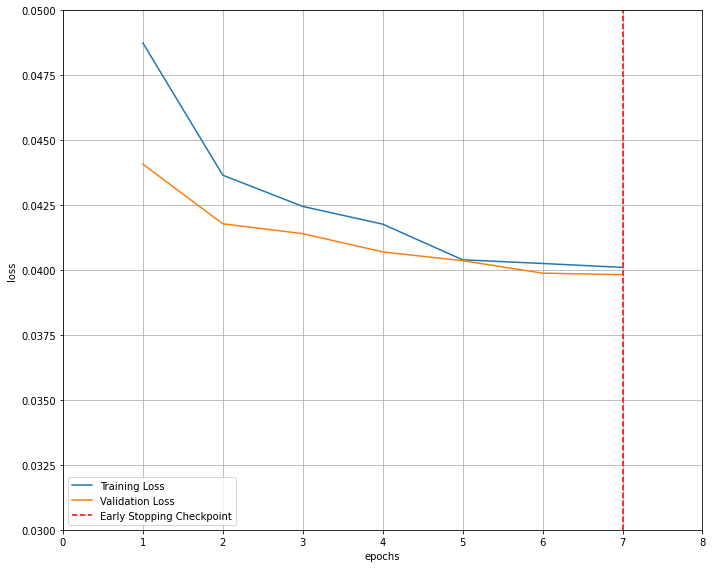

In [ ]:
# 훈련이 진행되는 과정에 따라 loss를 시각화
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# validation loss의 최저값 지점을 찾기
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0.03, 0.05) # 일정한 scale
plt.xlim(0, len(train_loss)+1) # 일정한 scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches = 'tight')

Model Save

In [ ]:
import joblib

saving_path = "/content/drive/MyDrive/이미지초해상화/models/SwinIR/"
os.makedirs(saving_path, exist_ok = True)

joblib.dump(best_swinir, f'{saving_path}swinir_patches_epochs:{CFG["SWIN_EPOCHS"]}_lr:{CFG["SWIN_LEARNING_RATE"]}_batch:{CFG["SWIN_TRAIN_BATCH"]}.pkl')

['/content/drive/MyDrive/이미지초해상화/models/SwinIR/swinir_patches_epochs:7_lr:0.0003_batch:4.pkl']

### Testing

Model Load

In [ ]:
import joblib
saving_path = "/content/drive/MyDrive/이미지초해상화/models/SwinIR/"
os.chdir(saving_path) #경로 가져오기
os.getcwd()

loaded_model = joblib.load(f'./swinir_patches_epochs:{CFG["SWIN_EPOCHS"]}_lr:{CFG["SWIN_LEARNING_RATE"]}_batch:{CFG["train_batch"]}.pkl')

Inference

In [ ]:
pred_img_list, pred_name_list = inference(loaded_model, test_loader, device)

  0%|          | 0/882 [00:00<?, ?it/s]

**Patch Merge**

여기서는 7x7 patch들을 overlap되는 것을 평균화하여 unpatchify 한다.

patch 붙이기 : patch_size와 stride가 다른 경우

도화지(np.zeros)에 predicted patches를 하나씩 붙인다(더한다.) 해당 posiztion mark(1)를 별도로 저장

이후, 전체 이미지 / mask

고려할 점 : 이미지가 2d가 아니라 3차원임(RGB channel 3)
그냥 unpatchify 써도 될 듯 (겹치지만 어차피 연속적인 patch임)

In [ ]:
pred_img, pred_name = full_img_from_patches(pred_img_list, pred_name_list)

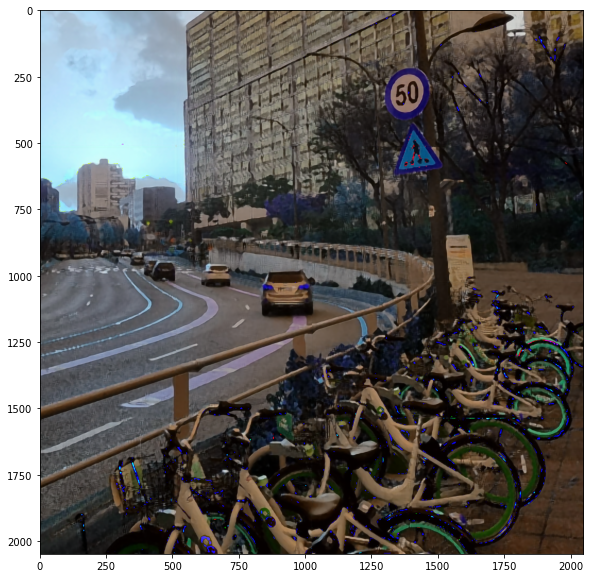

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(pred_img[0])

#plt.imshow는 그대로 R,G,B 형태로 보여주기 때문에 원래 BGR의 이미지는 BGR형태로 보임 
#cv2_imshow는 B,G,R 형태로 변환하기 때문에 원래 BGR의 이미지는 RGB형태로 보임 

Save

In [ ]:
saving_path = "/content/drive/MyDrive/이미지초해상화/Submission/SwinIR/"
os.makedirs(saving_path, exist_ok = True)
os.chdir(saving_path)
os.getcwd()

sub_imgs = []

for path, img in tqdm(zip(pred_name, pred_img)):
  cv2.imwrite(path, img) # 픽셀값으로 이미지 형성
  sub_imgs.append(path)

submission = zipfile.ZipFile("swin_submission.zip", "w")# 압축파일 형성

for path in sub_imgs:
  submission.write(path) #압축파일에 이미지들 추가

submission.close()
print("Done")

0it [00:00, ?it/s]

Done
